In [271]:
import networkx as nx
import pandas as pd
import math
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
from collections import deque
import random
from scipy import stats

In [168]:
df = pd.read_csv('twitter_small_data.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,node1,node2
0,253601,1
1,20980,2
2,46231,3
3,154918,4
4,26370,5


In [169]:
G = nx.from_pandas_edgelist(df.iloc[:], source = 'node1', target = 'node2', create_using=nx.DiGraph())

In [185]:
Grev = G.reverse()

In [186]:
def new_centrality(G, gamma = 0.10, k=2, u = None):
    '''
    G: directed graph G
    gamma: discount factor
    k: degree of depth of our search (not recommended to do >3)
    u: return for only a specific set of nodes (example below)
    '''
    G = G.reverse()  # create a reversed graph view
    if u is None:
        nodes = list(G.nodes)
    else:
        nodes = u
    centrality_dict = {}
    for n in tqdm.tqdm(nodes):
        centrality_dict[n] = new_centrality_helper(G, n, gamma=gamma, k=k, curr_depth = 0)
    G = G.reverse()
    return centrality_dict

def new_centrality_helper(G, n, gamma = 0.25, k=2, curr_depth = 0):
    if (curr_depth > k):
        return 0
    centrality = 0;
    for neighbor in G.neighbors(n):
        centrality += new_centrality_helper(G, neighbor, gamma, k, curr_depth + 1)
    return math.exp(-gamma * curr_depth) + centrality

In [234]:
def get_subgraph(G, node, k=2):
    G = G.reverse()
    q = deque() # queue of nodes
    nodelist = []
    q.append(node)
    for _ in tqdm.tqdm(range(k+1)):
        length = len(q)
        for __ in range(length):
            curr = q.popleft()
            for n in G.neighbors(curr): q.append(n)
            nodelist.append(curr)
    H=nx.subgraph(G, nodelist)
    G = G.reverse()
    return H
    
#     H=nx.subgraph(G, neighbors)
#     nx.draw(H, with_labels=True, font_weight='bold', node_color='lightblue', node_size=500)

In [235]:
def get_color_map(H, n):
    color_map = []
    for node in H:
        if node != n:
            color_map.append('lightblue')
        else: 
            color_map.append('red')
    return color_map

In [246]:
def get_layout(H, n, k):
    pos = {}
    degs = [0]*k
    for node in H:
        theta = random.uniform(0, 360)
        l = nx.shortest_path_length(H, n, node)
        degs[l-1]+=1
        pos[node] = np.array([l * (math.cos(theta)), l * math.sin(theta)])
        
    textstr = f"Layer graph for node {n}"
    for i in range(len(degs)):
        #if (i!=0): textstr+='\n'
        textstr += f'\ndegree-{i+1} friends: {degs[i]}'
    
    return pos, textstr

In [256]:
def make_plot(G, n, k=2):
    H = get_subgraph(G, n, k)
    pos, textstr = get_layout(H, n, k)
    color_map = get_color_map(H, n)
    fig, axe = plt.subplots(figsize=(16,10))

    
    nx.draw(H.reverse(), pos, ax = axe, with_labels=False, node_color=color_map, 
            font_weight='light', node_size=50, width=0.1, arrowsize=8)
    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    axe.text(0, 0.85, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

100%|██████████| 3/3 [00:00<00:00, 4309.22it/s]


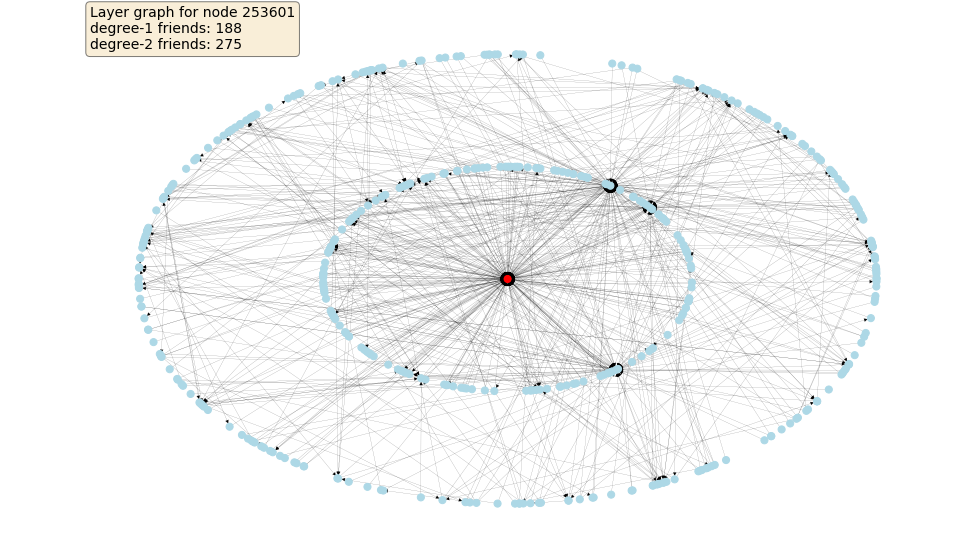

In [257]:
make_plot(G, 253601, k=2)

In [ ]:
make_plot(G, 253601, k=3)

In [196]:
df_new = pd.read_csv('centralities.csv')

In [197]:
df_new.iloc[253600]

Unnamed: 0              253600.000000
k=2 centrality               0.000803
k=3 centrality               0.008952
pagerank                     0.000107
degree_centrality            0.001117
closeness_centrality         0.008210
Name: 253600, dtype: float64

In [198]:
df_new.head()

,Unnamed: 0,k=2 centrality,k=3 centrality,pagerank,degree_centrality,closeness_centrality
0,0,0.000286,0.000921,0.000002,0.000002,0.006794
1,1,0.000620,0.001890,0.000012,0.000002,0.054225
2,2,0.000174,0.002353,0.000009,0.000002,0.050009
3,3,0.000446,0.002919,0.000002,0.000002,0.033050
4,4,0.000656,0.001988,0.000021,0.000002,0.055631


Text(0, 0.5, 'k=2 centrality')

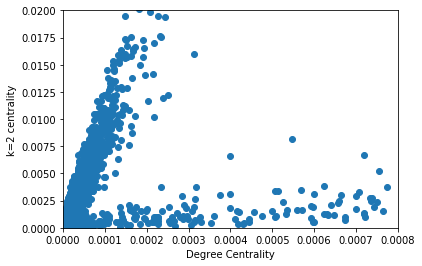

In [199]:
plt.scatter(df_new["degree_centrality"][:100000], df_new["k=2 centrality"][:100000])
plt.xlim((0, 8e-4))
plt.ylim((0, 20e-3))
plt.xlabel("Degree Centrality")
plt.ylabel("k=2 centrality")

Text(0, 0.5, 'k=2 centrality')

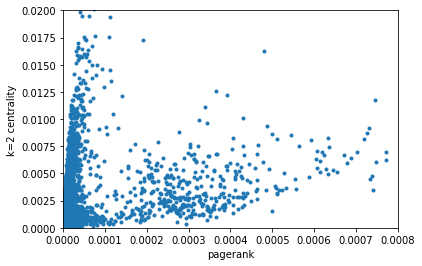

In [200]:
plt.scatter(df_new["pagerank"][:100000], df_new["k=2 centrality"][:100000], marker=".")
plt.xlim((0, 8e-4))
plt.ylim((0, 20e-3))
plt.xlabel("pagerank")
plt.ylabel("k=2 centrality")

### Find nodes with a high k=2 centrality but a low pagerank

In [207]:
def get_outliers(df):
    outliers = []
    for index, row in df[:100000].iterrows():
        if row["k=2 centrality"]/row["pagerank"] > 150 and row["k=2 centrality"]>0.0025: 
            outliers.append(row["Unnamed: 0"])
    return outliers

In [208]:
outliers = get_outliers(df_new)

In [314]:
#for i in range(10): print(df_new.loc[outliers[i]])


In [172]:
outliers[0]

247.0

### Analysis on nodes with high k=2 centrality and low pagerank

In [266]:
# Find neighbors of node 49
list(Grev[outliers[0]+1])

[44599, 63125, 83489, 127522, 239534, 243979, 259623, 299017, 326217]

In [308]:
outliers[0]

48.0

In [298]:
neighborlist = list(Grev[outliers[0]+1])
for n in neighborlist:
    print(f"node {n}: pagerank: {df_new.loc[n-1]['pagerank']} " + 
          f"({stats.percentileofscore(df_new['pagerank'], df_new.loc[n-1]['pagerank'], 'strict')}) " + 
          f"k=2 centrality: {df_new.loc[n-1]['k=2 centrality']} " + 
          f"({stats.percentileofscore(df_new['k=2 centrality'], df_new.loc[n-1]['k=2 centrality'], 'strict')} " +
          f"num following: {len(list(G[n]))}" )
    # print(df_new.loc[n-1])
    

node 44599: pagerank: 0.00031721554763566384 (99.95774846251349) k=2 centrality: 0.006178284666971133 (99.87621040771498 num following: 54
node 63125: pagerank: 0.0002255343794283938 (99.91895611523057) k=2 centrality: 0.005361085643242471 (99.82951133996674 num following: 71
node 83489: pagerank: 0.00015970614568438618 (99.86953911232239) k=2 centrality: 0.007200266350083264 (99.91401441493974 num following: 73
node 127522: pagerank: 0.00011423751352085791 (99.82012210941419) k=2 centrality: 0.0037819518395622656 (99.67557737590774 num following: 139
node 239534: pagerank: 3.9815153068110606e-05 (99.6054052317781) k=2 centrality: 0.0019346214617648454 (99.0563823294681 num following: 226
node 243979: pagerank: 3.4115430341998745e-05 (99.56414203434976) k=2 centrality: 0.002130758369548899 (99.17251228630235 num following: 260
node 259623: pagerank: 8.635983377480593e-05 (99.77119927653507) k=2 centrality: 0.0007755530500336236 (96.33054044905231 num following: 299
node 299017: pageran

In [309]:
pr = []
k2 = []
colors = []
for outlier in outliers:
    pr.append(df_new.loc[outlier]['pagerank'])
    k2.append(df_new.loc[outlier]['k=2 centrality'])
    colors.append('red')
    neighborlist = list(Grev[outlier+1])

    for n in neighborlist:
        pr.append(df_new.loc[n-1]['pagerank'])
        k2.append(df_new.loc[n-1]['k=2 centrality'])
        colors.append('blue')

Text(0, 0.5, 'k=2 centrality')

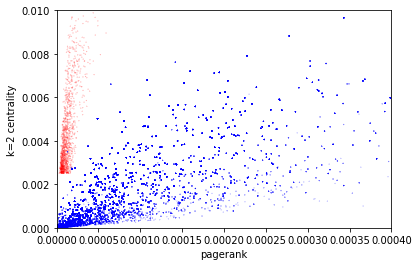

In [318]:
plt.scatter(pr, k2, c=colors, marker='.', s=0.05)
plt.xlim((0, 4e-4))
plt.ylim((0, 10e-3))
plt.xlabel("pagerank")
plt.ylabel("k=2 centrality")

In [325]:
np.mean(df_new['k=2 centrality']/df_new['pagerank'])

69.27450712160223

In [305]:
pr = []
k2 = []
colors = []
pr.append(df_new.loc[48]['pagerank'])
k2.append(df_new.loc[48]['k=2 centrality'])
colors.append('red')
neighborlist = list(Grev[outliers[0]+1])

for n in neighborlist:
    pr.append(df_new.loc[n-1]['pagerank'])
    k2.append(df_new.loc[n-1]['k=2 centrality'])
    colors.append('blue')

(0, 0.01)

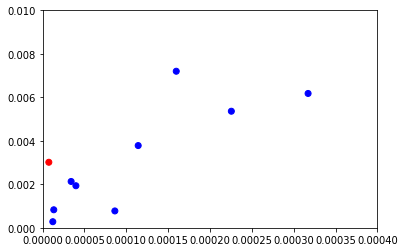

In [306]:
plt.scatter(pr, k2, c=colors)
plt.xlim((0, 4e-4))
plt.ylim((0, 10e-3))

In [267]:
print(df_new.loc[44599-1]["pagerank"])

0.00031721554763566384


In [263]:
print(df_new.loc[44599-1])

Unnamed: 0              44598.000000
k=2 centrality              0.006178
k=3 centrality              0.616390
pagerank                    0.000317
degree_centrality           0.001090
closeness_centrality        0.088515
Name: 44598, dtype: float64


In [264]:
G[44599]

AtlasView({49: {}, 2645: {}, 3859: {}, 4076: {}, 4741: {}, 5186: {}, 5476: {}, 6635: {}, 7040: {}, 8131: {}, 10883: {}, 11614: {}, 12723: {}, 13967: {}, 14676: {}, 15258: {}, 16727: {}, 16791: {}, 17255: {}, 17419: {}, 17455: {}, 18989: {}, 20505: {}, 23100: {}, 23891: {}, 24041: {}, 25201: {}, 26307: {}, 28224: {}, 28438: {}, 30715: {}, 31470: {}, 31650: {}, 31703: {}, 32338: {}, 33476: {}, 33576: {}, 33640: {}, 33740: {}, 33891: {}, 34866: {}, 36969: {}, 37500: {}, 37634: {}, 38071: {}, 38829: {}, 38894: {}, 40181: {}, 42120: {}, 43225: {}, 43478: {}, 44136: {}, 44376: {}, 44530: {}})

AtlasView({44599: {}, 63125: {}, 83489: {}, 127522: {}, 239534: {}, 243979: {}, 259623: {}, 299017: {}, 326217: {}})

100%|██████████| 4/4 [00:00<00:00, 34.40it/s]


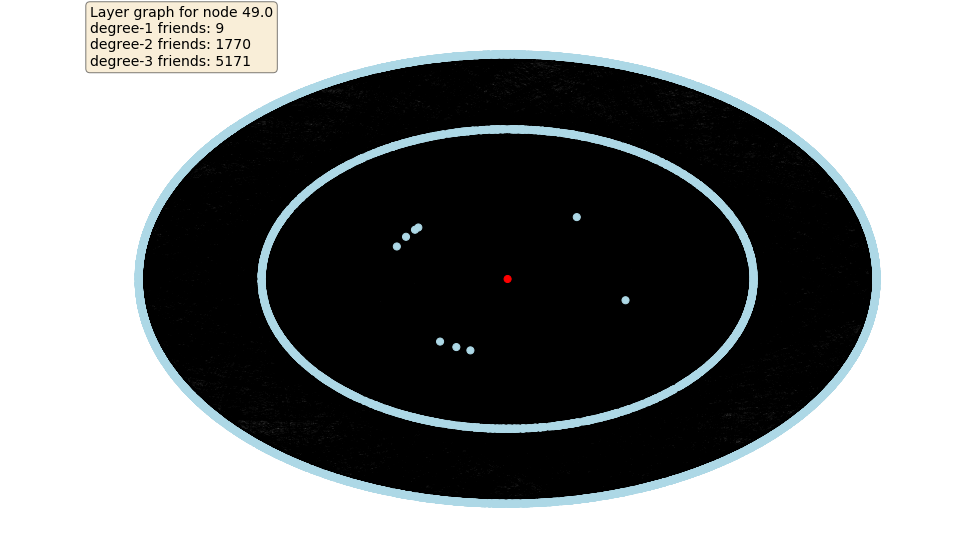

In [258]:
make_plot(G, outliers[0]+1, k=3)

100%|██████████| 4/4 [00:00<00:00, 45.47it/s]


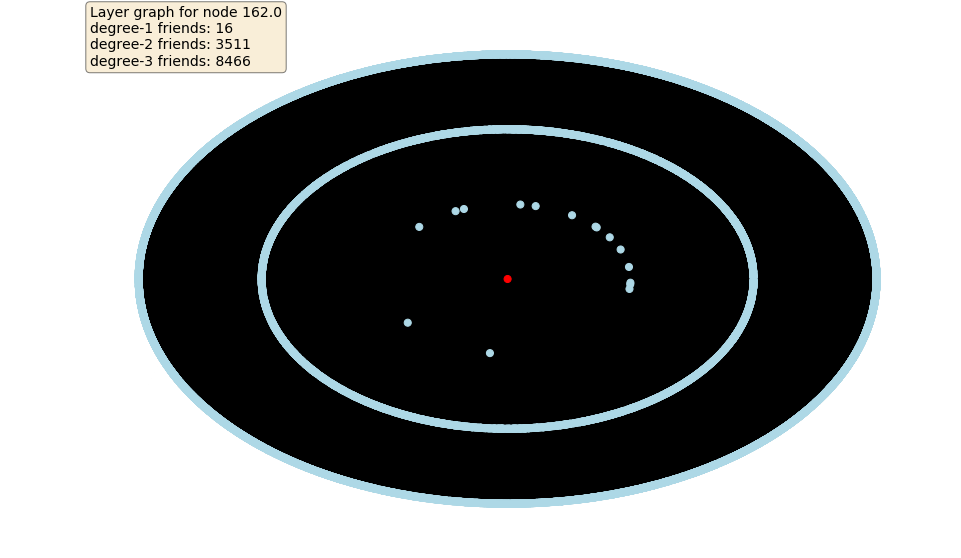

In [259]:
make_plot(G, outliers[1]+1, k=3)

In [100]:
deg_centralities = nx.degree_centrality(G)
deg_centralities_arr = np.array(sorted(deg_centralities.items()))

In [180]:
deg_centralities[248]

0.00015072223128202847

In [182]:
G.reverse()[248]

AtlasView({82537: {}, 145763: {}, 170931: {}, 251374: {}, 110975: {}, 231204: {}, 340010: {}, 306275: {}, 6552: {}, 15376: {}, 17694: {}, 19073: {}, 21609: {}, 41605: {}, 44239: {}, 74639: {}, 85489: {}, 86852: {}, 88760: {}, 91124: {}, 98981: {}, 111193: {}, 114612: {}, 116047: {}, 116132: {}, 137973: {}, 142026: {}, 146056: {}, 156861: {}, 173630: {}, 179419: {}, 181140: {}, 186860: {}, 187200: {}, 191143: {}, 219700: {}, 219753: {}, 222014: {}, 227232: {}, 231990: {}, 238057: {}, 250812: {}, 256596: {}, 262689: {}, 267028: {}, 268764: {}, 301512: {}, 302320: {}, 306328: {}, 308054: {}, 324061: {}, 324142: {}, 326894: {}, 336097: {}, 344315: {}, 349210: {}, 351617: {}, 377069: {}, 382439: {}, 389036: {}, 402304: {}})

In [41]:
H = get_subgraph(G, 253601)

100%|██████████| 3/3 [00:00<00:00, 1671.48it/s]


In [ ]:
pos = get_layout(H, 253601)

In [89]:
color_map = get_color_map(H, 253601)